# Mention Detection

- The goal in this notebook is to extract the entities from the free text

- We just want to tell whether the token is entity or not

- The result from this notebook is to be used for the second Stage of Entity Linking where we take the detected entities from here and disambiguate them in Knowledge base

In [2]:
%%capture

!pip install seqeval
#!pip install -U tensorflow

import json
import csv
import copy

import numpy as np
import pandas as pd
from tqdm import tqdm

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing import text, sequence
from tensorflow.keras.layers import Input, Bidirectional, Dense, LSTM, TimeDistributed, Layer
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
import tensorflow.keras.backend as K

from seqeval.metrics import classification_report, f1_score, accuracy_score
from seqeval.metrics.sequence_labeling import get_entities
from seqeval.scheme import IOB2

from transformers import BertTokenizer, BertConfig, TFBertModel

## Starting TPU environment

In [3]:
tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

## Reading the data

In [4]:
def reformat_data(data_file):
    with open(data_file, 'r') as file:
        article_sentences, article_labels = [], []
        sentence_tokens, sentence_labels = [], []
        
        for line in file.readlines():
            if line == '\n':
                if sentence_labels != []:
                    article_sentences.append(sentence_tokens)
                    article_labels.append(sentence_labels)
                    sentence_tokens, sentence_labels = [], []
            else:
                token = line.split(" ")[0]
                label = line.split(" ")[1][:-1]
                sentence_tokens.append(token)
                sentence_labels.append(label)
        
        article_sentences.append(sentence_tokens)
        article_labels.append(sentence_labels)
        #sentence_tokens, sentence_labels = [], []
                
    return article_sentences, article_labels
    
train_sentences, train_recog_labels = reformat_data("../input/thesis/st21pv_training_and_validation.txt")
test_sentences, test_recog_labels = reformat_data("../input/thesis/st21pv_testing.txt")

In [5]:
def build_detection_labels(recog_labels):
    detect_labels = []
    for seq_labels in recog_labels:
        labels = []
        for label in seq_labels:
            if label == "O":
                labels.append("O")
            else:
                labels.append(label[:2]+"Entity")
        detect_labels.append(labels)
    
    return detect_labels

train_detect_labels = build_detection_labels(train_recog_labels)
test_detect_labels = build_detection_labels(test_recog_labels)

This is to build dictionary for the labels inlcluding the [PAD] tag 

In [6]:
label_dict = {}
i = -1
for sent_labels in train_detect_labels:
    for label in sent_labels:
        if label not in label_dict.keys():
            i+=1
            label_dict[label] = i 

We add the [PAD] and X labels to the labels list, X label is the label we use later for subseqeuent subwords in subword tokenizer

In [7]:
label_dict = {'O': 0, 'B-Entity': 1, 'I-Entity': 2}
inv_label_map = {v: k for k, v in label_dict.items()}

## Tokenization using UMLS-BERT pretrained Tokenizer

In [8]:
umlsbert_tokenizer = BertTokenizer.from_pretrained('GanjinZero/UMLSBert_ENG', do_lower_case=True)

Downloading:   0%|          | 0.00/225k [00:00<?, ?B/s]

The tokenizer has vocab size of 28996. The tokenizer has special tokens for begin of sentence [CLS] and end of sentence [SEP] and [PAD]. The token [UNK] is used when the tokenizer can't recognize the word

In [9]:
umlsbert_tokenizer

PreTrainedTokenizer(name_or_path='GanjinZero/UMLSBert_ENG', vocab_size=28895, model_max_len=1000000000000000019884624838656, is_fast=False, padding_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})

This is add special tokens [CLS] and [SEP]. The token [CLS] at the start of each sentence and [SEP] at the end of each sentence, This is the way that BERT model has been trained on and it expect the input data to be in this way in order to know where is the start and end of each sentence

In [10]:
for i, sample_sent in enumerate(train_sentences):
    marked_sent = ["[CLS]"]
    marked_sent.extend(sample_sent)
    marked_sent.append("[SEP]")
    train_sentences[i] = marked_sent

for i, sample_sent in enumerate(test_sentences):
    marked_sent = ["[CLS]"]
    marked_sent.extend(sample_sent)
    marked_sent.append("[SEP]")
    test_sentences[i] = marked_sent

The special tokens [CLS] and [SEP] are labled with 'O' tag

In [11]:
for i, labels in enumerate(train_detect_labels):
    marked_labels = ["O"]
    marked_labels.extend(labels)
    marked_labels.append("O")
    train_detect_labels[i] = marked_labels

for i, labels in enumerate(test_detect_labels):
    marked_labels = ["O"]
    marked_labels.extend(labels)
    marked_labels.append("O")
    test_detect_labels[i] = marked_labels
    
for i, labels in enumerate(train_recog_labels):
    marked_labels = ["O"]
    marked_labels.extend(labels)
    marked_labels.append("O")
    train_recog_labels[i] = marked_labels

for i, labels in enumerate(test_recog_labels):
    marked_labels = ["O"]
    marked_labels.extend(labels)
    marked_labels.append("O")
    test_recog_labels[i] = marked_labels

The way that BERT model tokenize words is by break the word into several subwords or WordPiece tokenization (Wu et al.,2016) and assign a uninque token for each subword. 

In [12]:
print(umlsbert_tokenizer.encode('I-Macroaggregated Albumin')[1:-1])
test = umlsbert_tokenizer.tokenize('I-Macroaggregated Albumin')
print(test)
print(umlsbert_tokenizer.convert_tokens_to_ids(test))

[50, 16, 9721, 19458, 1735, 6306]
['i', '-', 'macro', '##aggreg', '##ated', 'albumin']
[50, 16, 9721, 19458, 1735, 6306]


The following is used to tokenize each word after breaking it into subwords. We only set the first word with the original label and the rest following subwords, we assign the X label to them. This is following the original BERT article: https://arxiv.org/pdf/1810.04805.pdf)

In [13]:
def tokenize_and_preserve_labels(sentence, detect_labels, recog_labels):
    tokenized_sentence = []
    det_labels = []
    rec_labels = []
    masks = []
    
    for word, detect_label, recog_label in zip(sentence, detect_labels, recog_labels):

        tokenized_word = umlsbert_tokenizer.tokenize(word)
        n_subwords = len(tokenized_word)

        tokenized_sentence.extend(tokenized_word)
        
        if n_subwords <= 1:
            det_labels.extend([detect_label]*n_subwords) 
            rec_labels.extend([recog_label]*n_subwords)
            masks.extend([1]*n_subwords)
        else:
            det_labels.extend([detect_label]+["O"]*(n_subwords-1))
            rec_labels.extend([recog_label]+["O"]*(n_subwords-1))
            masks.extend([1]+[0]*(n_subwords-1))
    return tokenized_sentence, det_labels, rec_labels, masks

In [14]:
tokenized_train_texts_and_labels = [
    tokenize_and_preserve_labels(sent, det_labs, rec_labs)
    for sent, det_labs, rec_labs in zip(tqdm(train_sentences), train_detect_labels, train_recog_labels)
]
tokenized_test_texts_and_labels = [
    tokenize_and_preserve_labels(sent, det_labs, rec_labs)
    for sent, det_labs, rec_labs in zip(tqdm(test_sentences), test_detect_labels, test_recog_labels)
]

100%|██████████| 8687/8687 [00:22<00:00, 388.37it/s]


In [15]:
tokenized_train_texts = [token_label_pair[0] for token_label_pair in tokenized_train_texts_and_labels]
train_detect_labels = [token_label_pair[1] for token_label_pair in tokenized_train_texts_and_labels]
train_recog_labels = [token_label_pair[2] for token_label_pair in tokenized_train_texts_and_labels]
train_masks = [token_label_pair[3] for token_label_pair in tokenized_train_texts_and_labels]

tokenized_test_texts = [token_label_pair[0] for token_label_pair in tokenized_test_texts_and_labels]
test_detect_labels = [token_label_pair[1] for token_label_pair in tokenized_test_texts_and_labels]
test_recog_labels = [token_label_pair[2] for token_label_pair in tokenized_test_texts_and_labels]
test_masks = [token_label_pair[3] for token_label_pair in tokenized_test_texts_and_labels]

In [16]:
def text_stats():
    tokens_dict = {}
    lengths = []
    i = 0
    for txt in [tokenized_test_texts_and_labels, tokenized_train_texts_and_labels]:
        for sentence in txt:
            lengths.append(len(sentence[0]))
            for word in np.unique(sentence[0]):
                if word.lower() not in tokens_dict.keys():
                    i+=1
                    tokens_dict[word.lower()] = i
                    
    return tokens_dict, np.max(lengths)
            
tokens_dict, maxlen = text_stats()

print("Maximum length of the sentences after breaking words into subwords is: ", maxlen)

Maximum length of the sentences after breaking words into subwords is:  302


This is to pad all senteneces with zeros into the maximum length

In [17]:
train_ids = sequence.pad_sequences([umlsbert_tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_train_texts],
                          maxlen=maxlen, dtype="long", value=0.0,
                          truncating="post", padding="post")

train_labels = sequence.pad_sequences([[label_dict.get(l) for l in lab] for lab in train_detect_labels], 
                             maxlen=maxlen, value=label_dict["O"], padding="post", 
                             dtype="long", truncating="post")

test_ids = sequence.pad_sequences([umlsbert_tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_test_texts],
                          maxlen=maxlen, dtype="long", value=0.0,
                          truncating="post", padding="post")

test_labels = sequence.pad_sequences([[label_dict.get(l) for l in lab] for lab in test_detect_labels],
                     maxlen=maxlen, value=label_dict["O"], padding="post",
                     dtype="long", truncating="post")

test_mask = sequence.pad_sequences([[l for l in lab] for lab in test_masks],
                     maxlen=maxlen, value=label_dict["O"], padding="post",
                     dtype="long", truncating="post")

train_mask = sequence.pad_sequences([[l for l in lab] for lab in train_masks], 
                             maxlen=maxlen, value=label_dict["O"], padding="post", 
                             dtype="long", truncating="post")

This is used to convert the lebels into one hot encoded labels

In [18]:
train_labels_ohe = [to_categorical(i, num_classes=3) for i in train_labels]
test_labels_ohe = [to_categorical(i, num_classes=3) for i in test_labels]

Now we cast sequences, labels and masks into tensors

In [19]:
train_seq = train_ids
test_seq = test_ids
train_seq = tf.cast(train_seq, tf.float32) 
test_seq = tf.cast(test_seq, tf.float32)
train_labels = tf.cast(train_labels_ohe, tf.float32)
test_labels = tf.cast(test_labels_ohe, tf.float32)
train_mask = tf.cast(train_mask, tf.float32)
test_mask = tf.cast(test_mask, tf.float32)

In [20]:
print(train_seq.shape)
print(train_mask.shape)
print(train_labels.shape)
print(test_seq.shape)
print(test_mask.shape)
print(test_labels.shape)

(34830, 302)
(34830, 302)
(34830, 302, 3)
(8687, 302)
(8687, 302)
(8687, 302, 3)


## UMLSBert LSTM Network

Evaluation metrics, The mask is to make sure that the [PAD] token was not taken into account when calculating the metrics

In [21]:
def mask(m, q):
    mask = tf.math.reduce_any(tf.not_equal(m, q), axis=-1)
    return mask

def recall(y_true, y_pred):
    pad = tf.constant([1., 0., 0.], dtype=tf.float32)
    mask_ = mask(y_true, pad)
    masked_y_true = tf.boolean_mask(y_true, mask_)
    masked_y_pred = tf.boolean_mask(y_pred, mask_)
    true_positives = K.sum(K.round(K.clip(masked_y_true * masked_y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(masked_y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision(y_true, y_pred):
    pad = tf.constant([1., 0., 0.], dtype=tf.float32)
    mask_ = mask(y_true, pad)
    masked_y_true = tf.boolean_mask(y_true, mask_)
    masked_y_pred = tf.boolean_mask(y_pred, mask_)
    true_positives = K.sum(K.round(K.clip(masked_y_true * masked_y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(masked_y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


def f1(y_true, y_pred):
    precision_ = precision(y_true, y_pred)
    recall_ = recall(y_true, y_pred)
    return 2*((precision_*recall_)/(precision_+recall_+K.epsilon()))

Important Notes about the following network

- We take the last four layer hidden states (embeddings) of the BERT model and take average of them before feeding them into the Bi-LSTM layer.  (reference: BERT paper https://arxiv.org/pdf/1810.04805.pdf)

- The number of labels to be predicted are 4, This means that [PAD] is included in the labels

- The BERT model is freezed while training 

In [22]:
def build_bert_lstm_model():
    #config = BertConfig.from_json_file('./umlsbert/config.json')
    #config.output_hidden_states=True
    encoder = TFBertModel.from_pretrained("GanjinZero/UMLSBert_ENG", 
                                          output_hidden_states=True, 
                                          from_pt=True, name='CODER')
    encoder.bert.trainable = False

    input_ids = Input(shape=(maxlen,), dtype=tf.int32, name="Input Ids")
    mask = Input(shape=(maxlen,), dtype=tf.int32, name="Input Mask")
    outputs = encoder(input_ids, attention_mask=mask)
    
    #  get last four layers (reference: BERT paper https://arxiv.org/pdf/1810.04805.pdf)
    last_four_layers = [outputs.hidden_states[i] for i in (-1, -2, -3, -4)]
    # sum them element wise
    sum_hidden_states = tf.math.add_n(last_four_layers)
    # take the mean of the vector 
    avg_emb = tf.math.scalar_mul(1/4, sum_hidden_states)
    
    #concat = tf.concat(last_four_layers, axis=-1)
    
    outputs = Bidirectional(LSTM(units=128, return_sequences=True, dropout=0.4, recurrent_dropout=0.4), 
                            merge_mode = 'concat', name='Bi-LSTM')(avg_emb)
    
    outputs = LSTM(units=128, dropout=0.4,  return_sequences=True, recurrent_dropout=0.4, name='LSTM')(outputs)
    
    outputs = (TimeDistributed(Dense(128, activation="relu"), name='TimeDistributed'))(outputs)

    outputs = (Dense(len(label_dict), activation="softmax", name='Output-Layer'))(outputs)

    bert_lstm = Model([input_ids, mask], outputs)
    
    bert_lstm.compile(loss="CategoricalCrossentropy",
                      metrics=[f1, precision, recall], 
                      optimizer=tf.keras.optimizers.Adam(0.0008))
    
    return bert_lstm

Start the model with the TPU environment we started earlier

In [62]:
tf.random.set_seed(42)

val_history = {}
for k_fold in tqdm(range(3)):
    print("KFold: ", k_fold+1)
    with tpu_strategy.scope(): 
        bert_lstm_model = build_bert_lstm_model()
        #bert_lstm_model.summary()
    val_history["bert_lstm_his{0}".format(k_fold)] = bert_lstm_model.fit((train_seq, train_mask), train_labels, 
                                        epochs = 30 , batch_size = 64, 
                                        validation_split = 0.3, verbose=0)

  0%|          | 0/3 [00:00<?, ?it/s]

KFold:  1


 33%|███▎      | 1/3 [18:06<36:13, 1086.97s/it]

KFold:  2


 67%|██████▋   | 2/3 [36:19<18:10, 1090.07s/it]

KFold:  3


100%|██████████| 3/3 [54:30<00:00, 1090.20s/it]


We tried the following hyperparameters:

LR : (0.001, 0.002, 0.0005, 0.001, 0.005), epochs : (7, 10, 20), units: (64, 128)

Notice the evaluation metrics that are used here are not strict mode. 

In [63]:
loss_plot = [[val_history["bert_lstm_his"+str(i)].history['loss'] for i in range(3)], 'Training Loss']
f1_plot = [[val_history["bert_lstm_his"+str(i)].history['f1'] for i in range(3)], 'Training F1']
val_loss_plot = [[val_history["bert_lstm_his"+str(i)].history['val_loss'] for i in range(3)], 'Validation Loss']
val_f1_plot = [[val_history["bert_lstm_his"+str(i)].history['val_f1'] for i in range(3)], 'Validation F1']
val_precision_plot = [[val_history["bert_lstm_his"+str(i)].history['val_precision'] for i in range(3)], 'Validation Precision']
precision_plot = [[val_history["bert_lstm_his"+str(i)].history['precision'] for i in range(3)], 'Training Precision']
recall_plot = [[val_history["bert_lstm_his"+str(i)].history['recall'] for i in range(3)], 'Training Recall']
val_recall_plot = [[val_history["bert_lstm_his"+str(i)].history['val_recall'] for i in range(3)], 'Validation Recall']

In [64]:
import math
import matplotlib.pyplot as plt
def make_plot(metric, val_metric, ylabel):
    epochs = range(1, 31)
    xint = range(min(epochs)+1, math.ceil(max(epochs))+1, 2)

    plt.figure(figsize=(25,15))
    plt.plot(epochs, metric[0][0],  label=metric[1], linewidth=4, c="#0000FF", )
    plt.plot(epochs, val_metric[0][0], label=val_metric[1], linewidth=4, c="#FFA500")
    plt.plot(epochs, metric[0][1],  linewidth=4, c="#0000FF", )
    plt.plot(epochs, val_metric[0][1], linewidth=4, c="#FFA500")
    plt.plot(epochs, metric[0][2],  linewidth=4, c="#0000FF", )
    plt.plot(epochs, val_metric[0][2],  linewidth=4, c="#FFA500")
    plt.xlabel('Epochs', fontsize=50)
    plt.ylabel(ylabel, fontsize=50)
    plt.legend(fontsize=50)
    plt.xticks(xint, fontsize=50)
    plt.yticks(fontsize=50)
    plt.grid()
    plt.tight_layout()
    plt.savefig(metric[1]+'.pdf')
    plt.show()

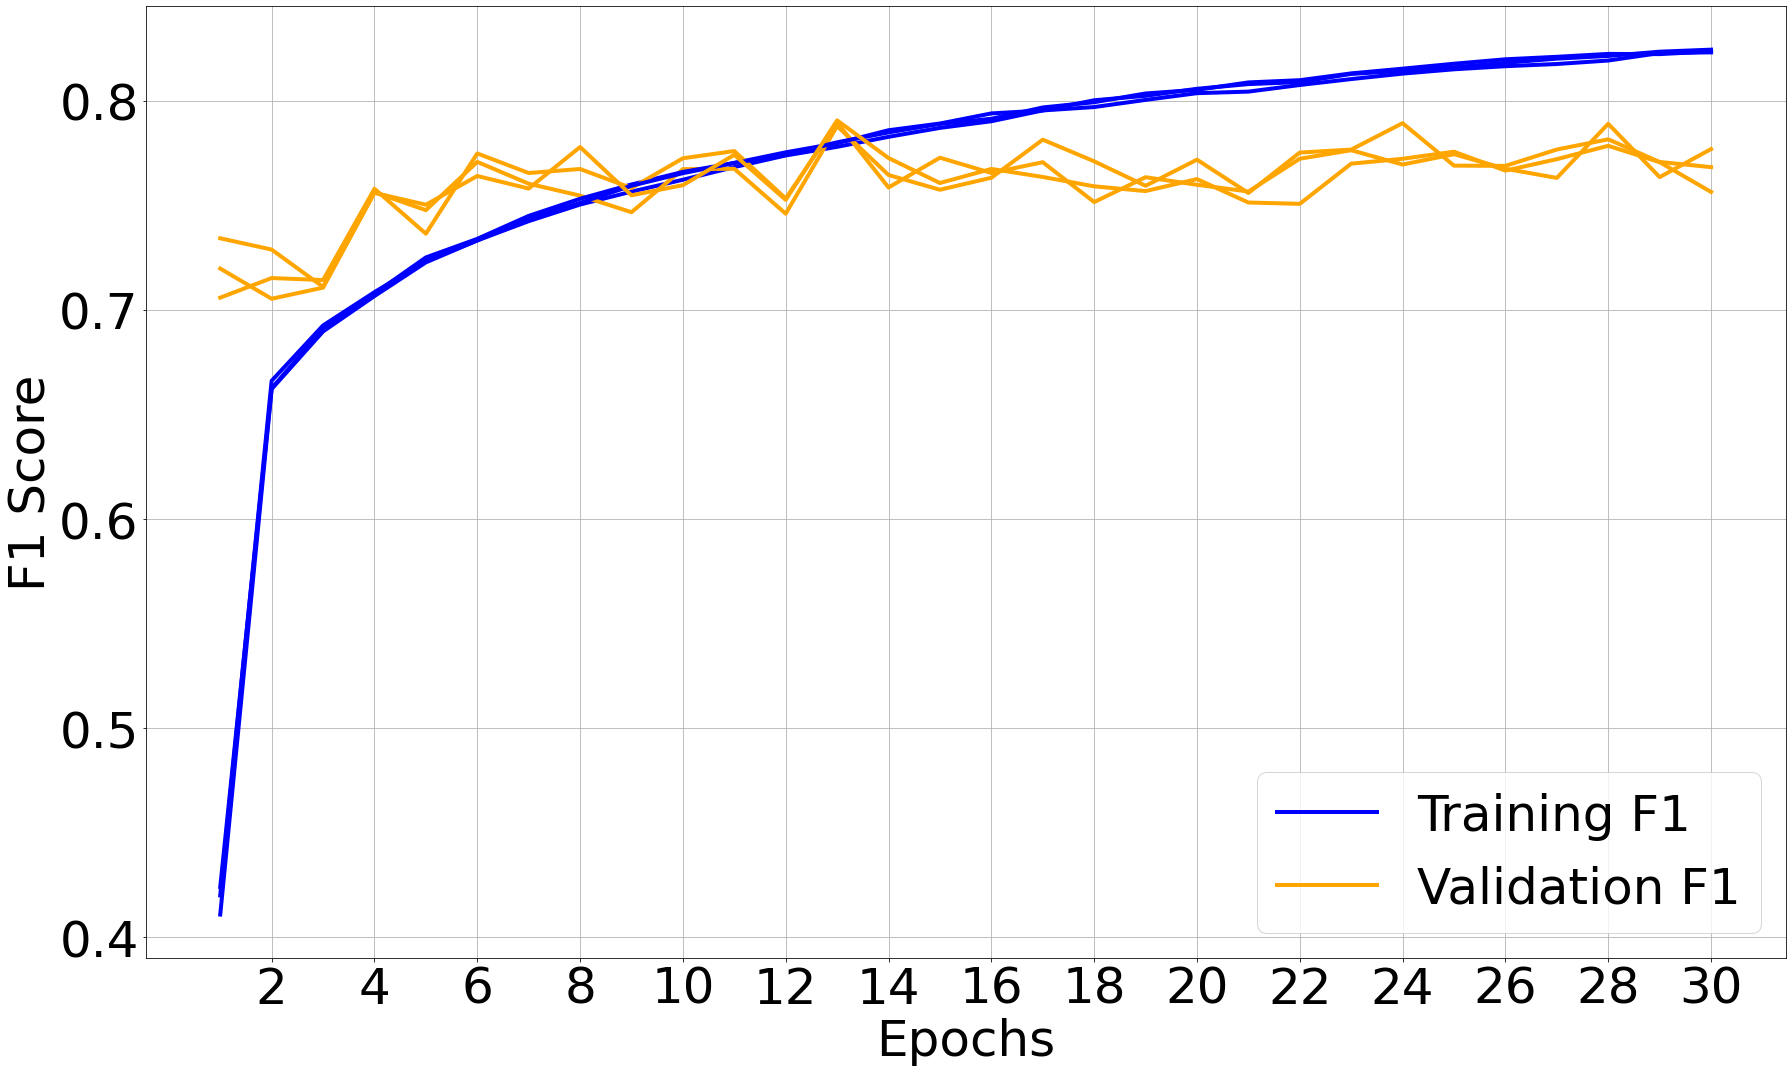

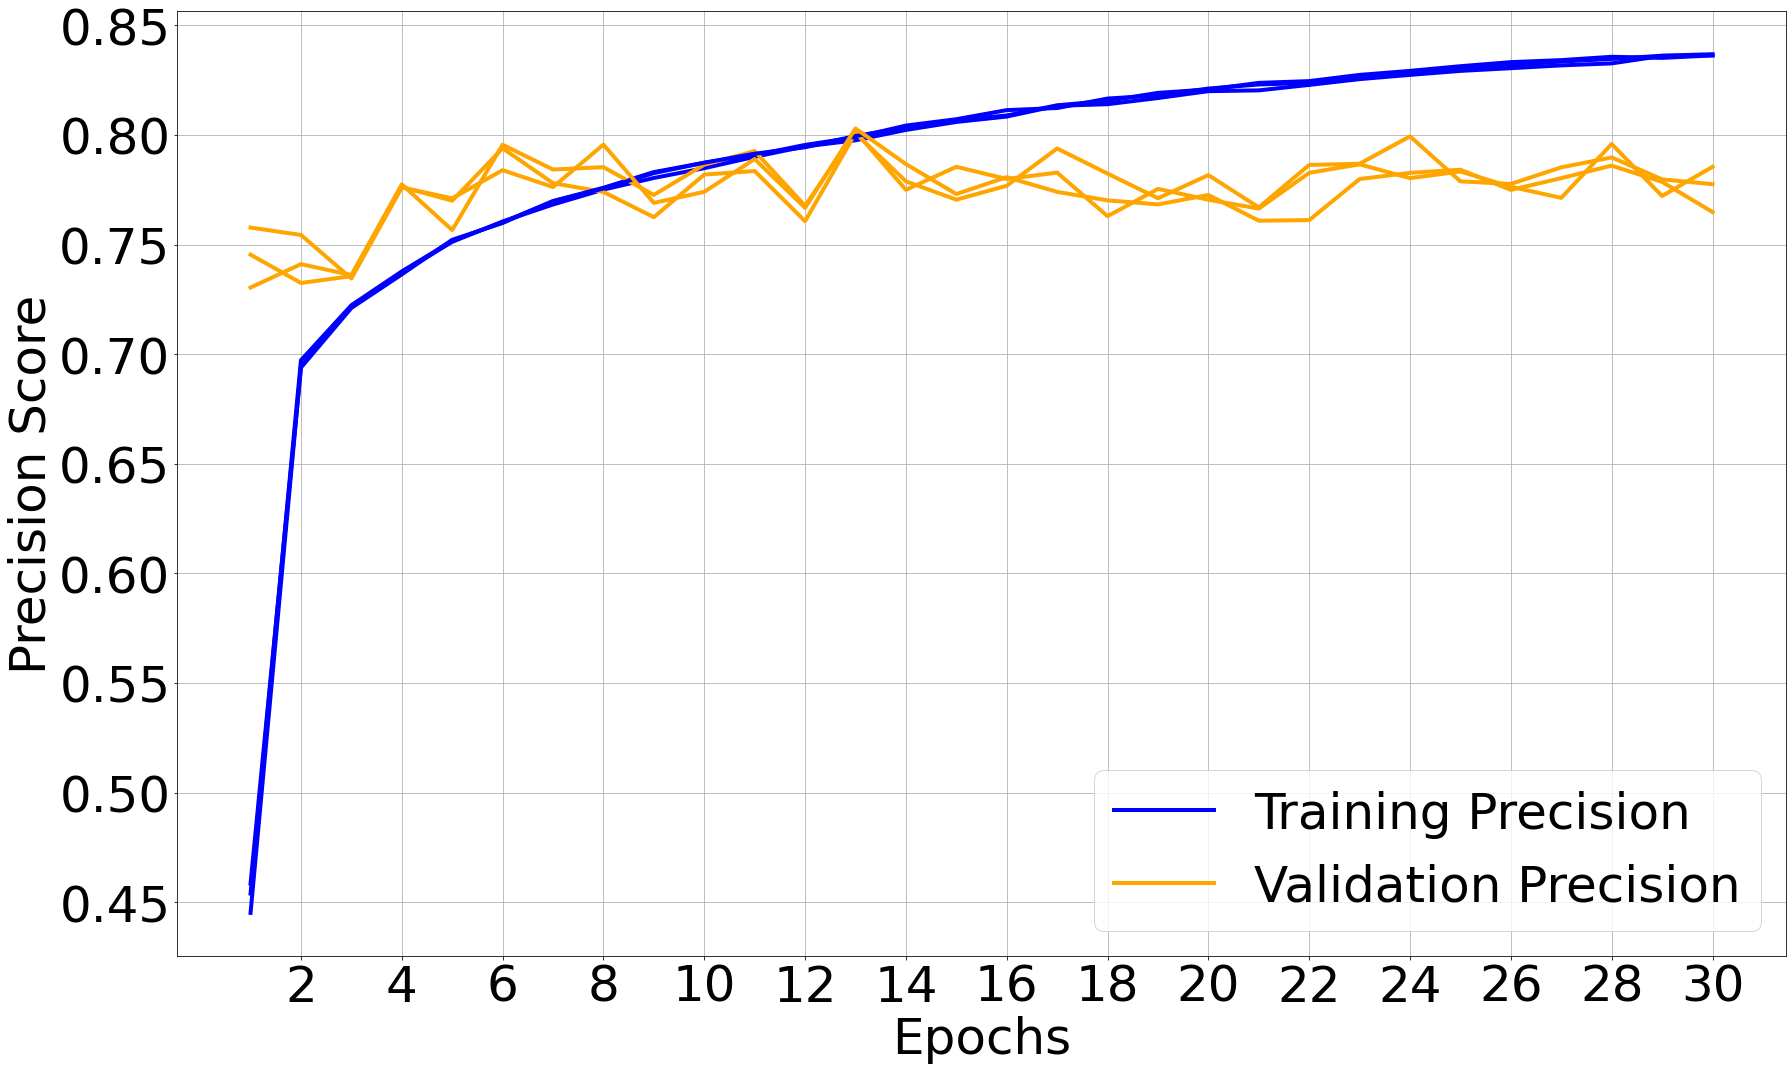

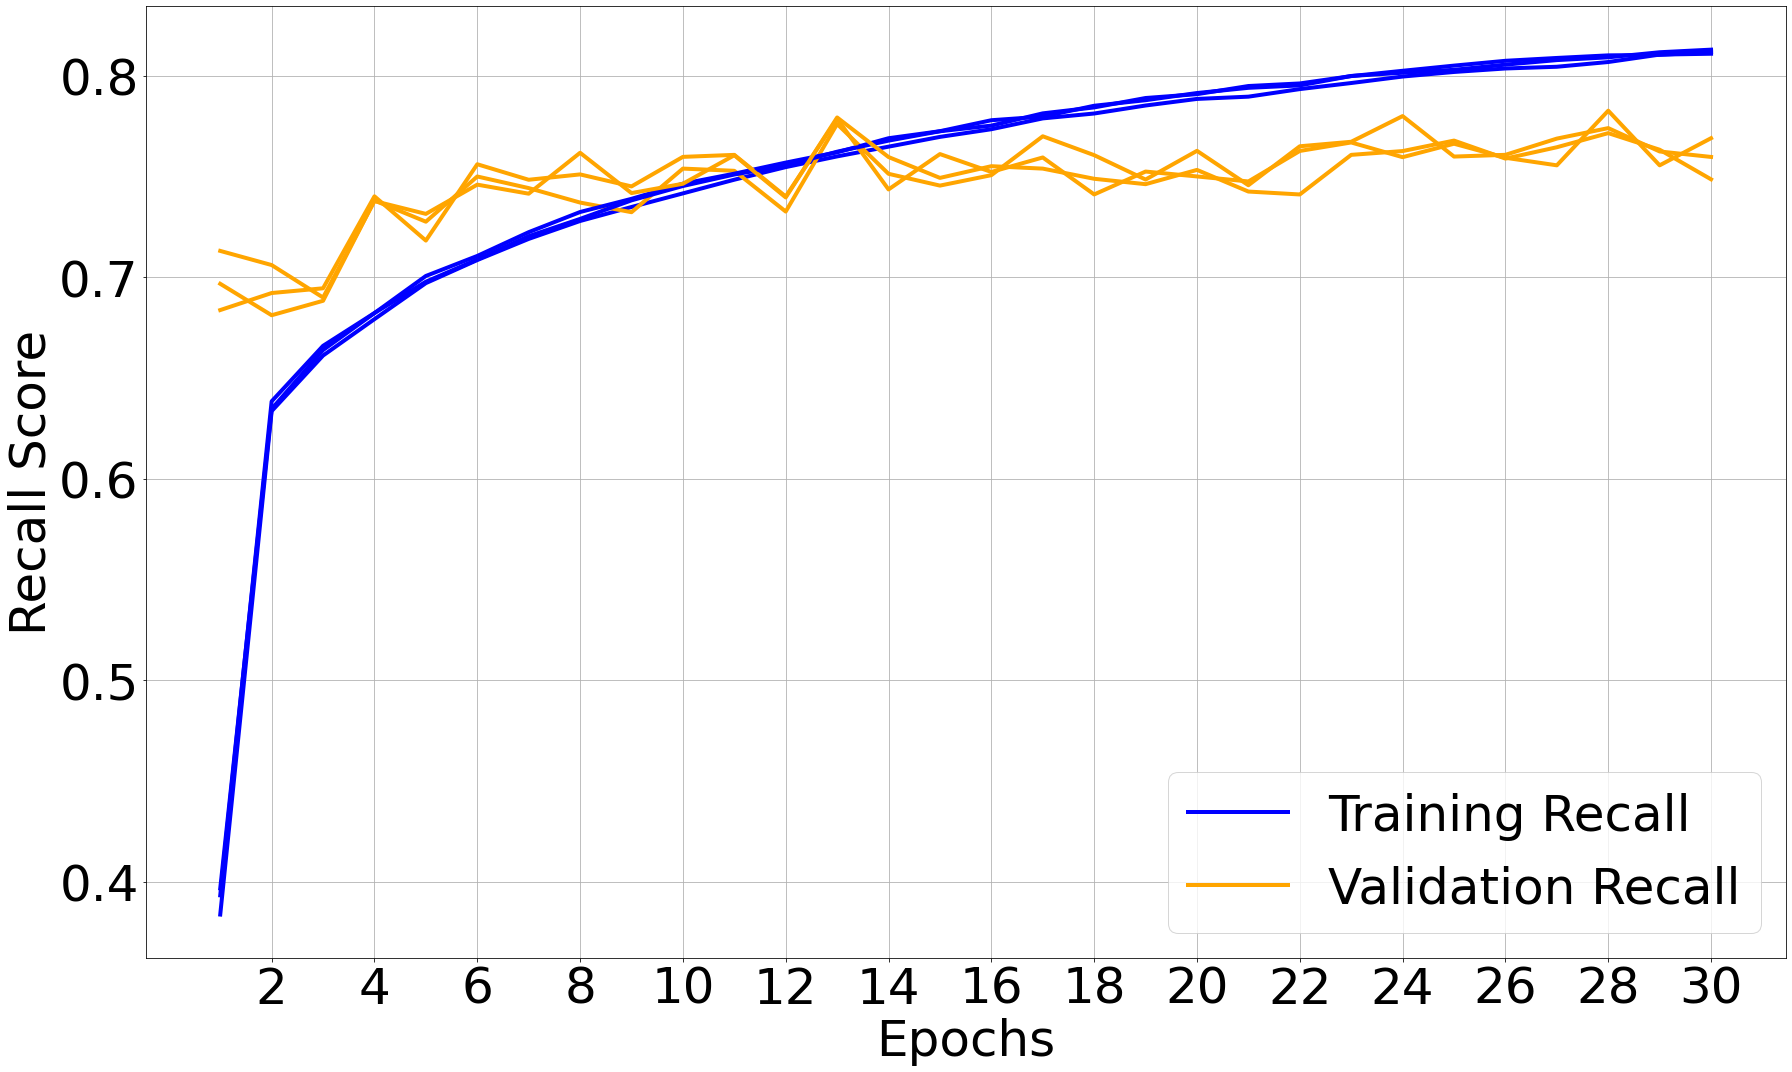

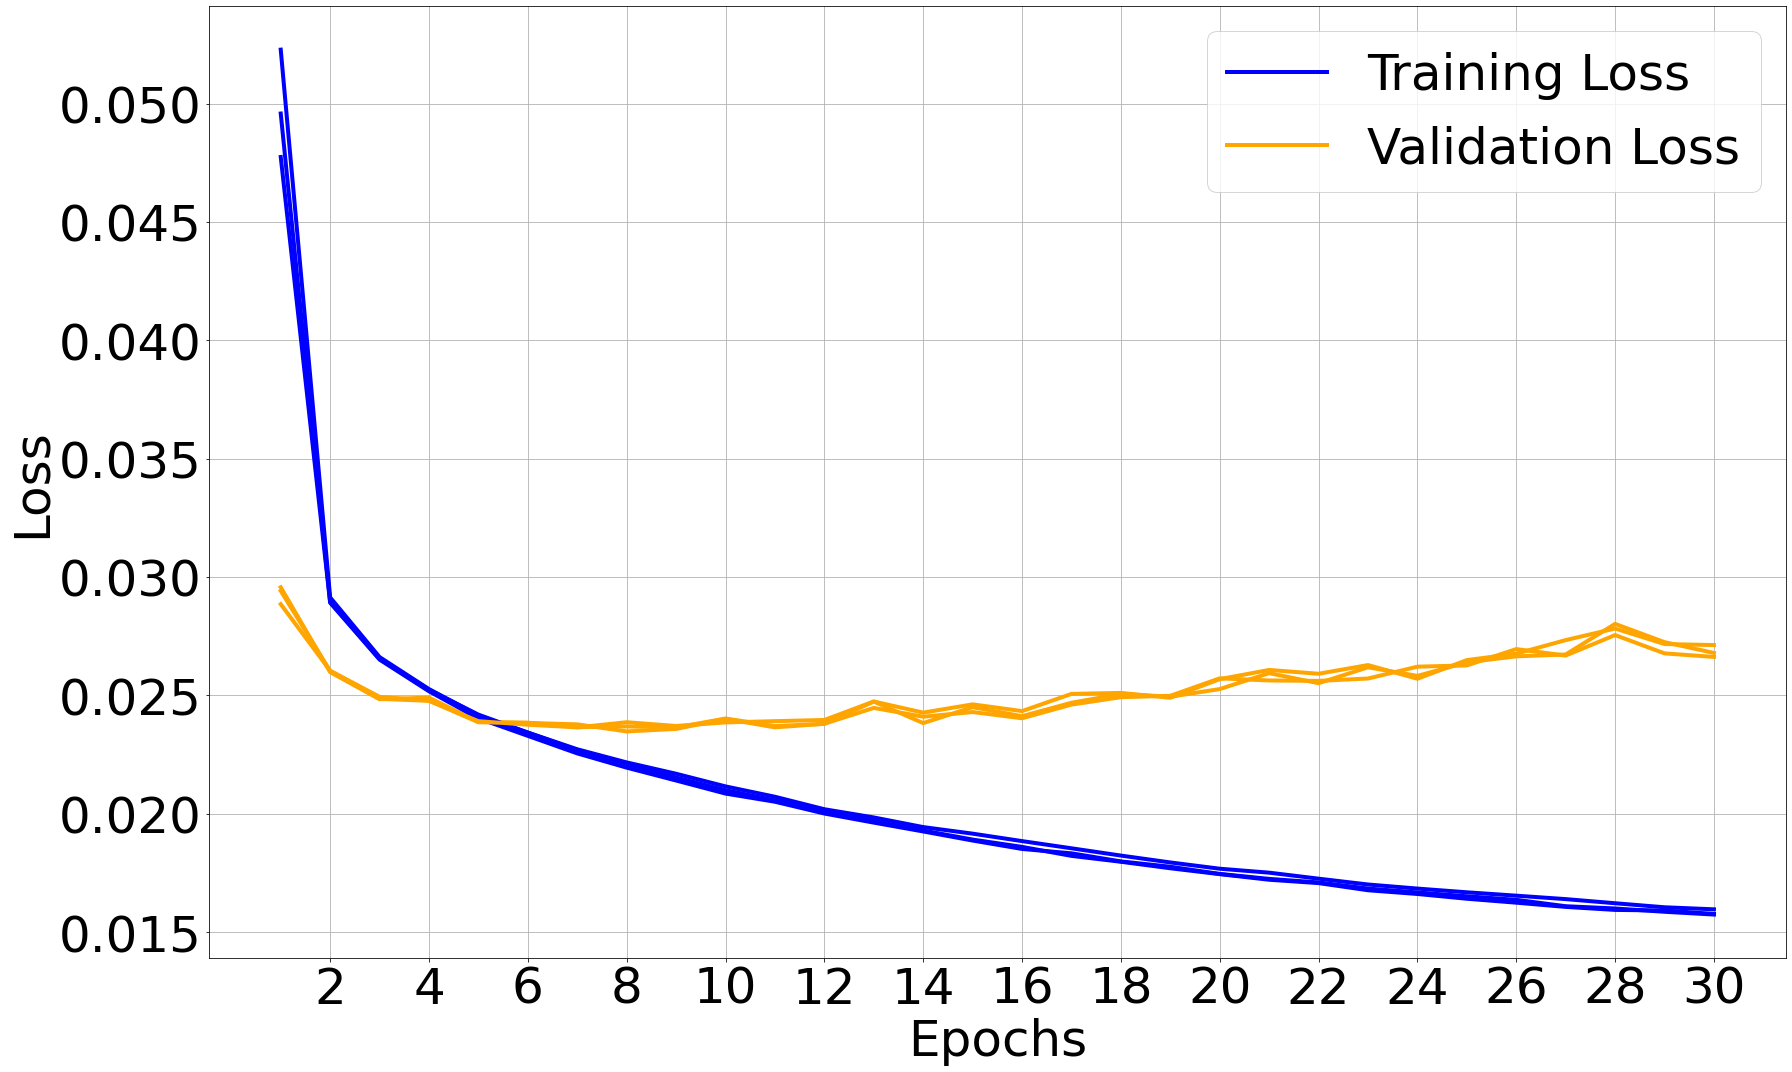

In [65]:
make_plot(f1_plot, val_f1_plot, 'F1 Score')
make_plot(precision_plot, val_precision_plot, 'Precision Score')
make_plot(recall_plot, val_recall_plot, 'Recall Score')
make_plot(loss_plot, val_loss_plot, 'Loss')

In [23]:
tf.random.set_seed(42)
with tpu_strategy.scope(): 
    final_lstm_model = build_bert_lstm_model()

Downloading:   0%|          | 0.00/462 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/438M [00:00<?, ?B/s]

In [24]:
final_lstm_model.fit((train_seq, train_mask), train_labels, epochs = 13, batch_size = 64, verbose=0)

## Eval

In [25]:
final_lstm_model.evaluate((test_seq, test_mask), test_labels)

272/272 [==============================] - 29s 60ms/step - loss: 0.0234 - f1: 0.7727 - precision: 0.7860 - recall: 0.7607


[0.023368272930383682,
 0.7727009654045105,
 0.785982072353363,
 0.7606620788574219]

> ## Example

In [26]:
test_pred = np.array(final_lstm_model.predict((test_seq, test_mask)))
example_sentence = test_sentences[2021]
example_tokens = umlsbert_tokenizer.convert_ids_to_tokens(test_seq[2021])
example_mask = test_mask[2021]
example_detect_gold = np.argmax(test_labels[2021], axis=-1)
example_recog_gold = test_recog_labels[2021]
example_detect_pred = np.argmax(test_pred[2021], axis=-1)

def merge_subwords(sent_tokens, sent_det_pred, sent_det_gold, sent_rec_gold):
    new_tokens, gold_det_labels, gold_rec_labels, predicted_det_labels = [], [], [], []
    for token, det_label_hat, det_label, rec_label in zip(sent_tokens, 
                                                          sent_det_pred, 
                                                          sent_det_gold, 
                                                          sent_rec_gold):
        if token != "[PAD]":
            if token.startswith("##"):
                new_tokens[-1] = new_tokens[-1] + token[2:]
            else:
                predicted_det_labels.append(inv_label_map[det_label_hat])
                gold_det_labels.append(inv_label_map[det_label])
                gold_rec_labels.append(rec_label)
                new_tokens.append(token)
                
    return new_tokens, gold_det_labels, gold_rec_labels, predicted_det_labels

(new_tokens, 
 gold_det_labels, 
 gold_rec_labels, 
 predicted_det_labels) = merge_subwords(example_tokens, 
                                        example_detect_pred, 
                                        example_detect_gold,
                                        example_recog_gold)

print("{0:35} {1:30} {2:30} {3:30}".format('Token', 'Detection Gold', 'Detection Prediction', 'Recognition Gold'))
print("{0:35} {1:30} {2:30} {3:30}".format('_____', '______________', '____________________', '________________'))

for token, det_label, rec_label, label_hat in zip(new_tokens, gold_det_labels, gold_rec_labels, predicted_det_labels):
    print("{0:35} {1:30} {2:30} {3:30}".format(token, det_label, label_hat, rec_label))  

Token                               Detection Gold                 Detection Prediction           Recognition Gold              
_____                               ______________                 ____________________           ________________              
[CLS]                               O                              O                              O                             
in                                  O                              O                              O                             
fact                                O                              O                              O                             
,                                   O                              O                              O                             
both                                O                              O                              O                             
the                                 O                              O                             

## Merge Entities

Merge B-Entity and I-Entity to form Entity

In [27]:
def merge_entities(sent_tokens, sent_pred, sent_gold, sent_recog_gold):
    (new_tokens, 
     gold_det_labels, 
     gold_rec_labels, 
     predicted_det_labels) = merge_subwords(sent_tokens, 
                                            sent_pred, 
                                            sent_gold,
                                            sent_recog_gold)
    
    merged_tokens = copy.copy(new_tokens)
    chunks_pred = get_entities(predicted_det_labels)
    det_preds = ["O"]*len(new_tokens)
    
    shift = 0
    for i, (chunk_type, chunk_start, chunk_end) in enumerate(chunks_pred):
        repeat = chunk_end - chunk_start + 1
        merged_tokens[chunk_start:chunk_end+1] = [' '.join(merged_tokens[chunk_start:chunk_end+1])]*repeat
        det_preds[chunk_start:chunk_end+1] = [chunk_type]*repeat

    return new_tokens, merged_tokens, gold_rec_labels, predicted_det_labels  

In [28]:
test_pred = np.array(final_lstm_model.predict((test_seq, test_mask)))
example_sentence = test_sentences[2021]
example_tokens = umlsbert_tokenizer.convert_ids_to_tokens(test_seq[2021])
example_mask = test_mask[2021]
example_detect_gold = np.argmax(test_labels[2021], axis=-1)
example_recog_gold = test_recog_labels[2021]
example_detect_pred = np.argmax(test_pred[2021], axis=-1)

new_tokens, merged_tokens, gold_rec_labels, det_preds = merge_entities(example_tokens, 
                                                                       example_detect_pred, 
                                                                       example_detect_gold,
                                                                       example_recog_gold)

print("{0:20} {1:20} {2:30} {3:30}".format('Token', 'Predicted Entity', 'Merged Predicted Span', 'Token Gold'))
print("{0:20} {1:20} {2:30} {3:30}".format('_____', '________________', '_____________________', '__________'))

for token, span, gold, det_label in zip(new_tokens, merged_tokens, gold_rec_labels, det_preds):
    print("{0:20} {1:20} {2:30} {3:30}".format(token, det_label, span, gold))  

Token                Predicted Entity     Merged Predicted Span          Token Gold                    
_____                ________________     _____________________          __________                    
[CLS]                O                    [CLS]                          O                             
in                   O                    in                             O                             
fact                 O                    fact                           O                             
,                    O                    ,                              O                             
both                 O                    both                           O                             
the                  O                    the                            O                             
resistive            O                    resistive                      O                             
and                  O                    and                   

This is intensive process as it requires to merge the subwords and words into entities

In [33]:
test_pred = np.argmax(final_lstm_model.predict((test_seq, test_mask)), axis=-1)
test_true = np.argmax(test_labels, axis=-1)

test_seq_predictions = []

for seq, seq_pred, seq_gold, seq_rec_gold in zip(tqdm(test_seq), test_pred, test_true, test_recog_labels):
    seq = umlsbert_tokenizer.convert_ids_to_tokens(seq)
    test_seq_predictions.append(merge_entities(seq, seq_pred, seq_gold, seq_rec_gold))

100%|██████████| 2797/2797 [22:54<00:00,  2.04it/s]


In [35]:
train_pred = np.argmax(final_lstm_model.predict((train_seq, train_mask)), axis=-1)
train_true = np.argmax(train_labels, axis=-1)

train_seq_predictions = []

(train_seq_portion, 
 train_pred_portion, 
 train_true_portion, 
 train_rec_gold_portion) = (
    train_seq[:3000], 
    train_pred[:3000], 
    train_true[:3000], 
    train_recog_labels[:3000])

for seq, seq_pred, seq_gold, seq_rec_gold  in zip(tqdm(train_seq_portion), train_pred_portion, train_true_portion, train_rec_gold_portion):
    seq = umlsbert_tokenizer.convert_ids_to_tokens(seq)
    train_seq_predictions.append(merge_entities(seq, seq_pred, seq_gold, seq_rec_gold))

100%|██████████| 3000/3000 [25:20<00:00,  1.97it/s]


## Saving predictions to csv

This csv is going to be used for the second step

In [38]:
def extract_rows(predictions):
    rows = []
    for seq, merged_seq, seq_pred, seq_gold in predictions:
        for entity, merged, entity_pred, gold in zip(seq, merged_seq, seq_pred, seq_gold):
            rows.append([entity, entity_pred, merged, gold])
    return rows

test_rows = extract_rows(test_seq_predictions)
train_rows = extract_rows(train_seq_predictions)

In [39]:
def save_csv(rows, name):
    fields = ['Tokens', 'Gold Label', 'Span', 'Detection Prediction']     
    with open(name+'.csv', 'w') as f: 
        write = csv.writer(f) 
        write.writerow(fields) 
        write.writerows(rows) 

save_csv(test_rows, 'test_prediction')
save_csv(train_rows, 'train_prediction')

In [40]:
saved_test_csv =  pd.read_csv('test_prediction.csv')
for_report_true_labels = []
for_report_pred_labels = []
true_seq_labels = []
pred_seq_labels = []

for row in tqdm(saved_test_csv.iterrows()):
    if row[1][0] == '[SEP]':
        true_seq_labels.append(row[1][1])
        pred_seq_labels.append(row[1][3])
        for_report_true_labels.append(true_seq_labels)
        for_report_pred_labels.append(pred_seq_labels)
        true_seq_labels, pred_seq_labels = [], []
    else:
        true_seq_labels.append(row[1][1][:2]+"Entity")
        pred_seq_labels.append(row[1][3])
        
print(classification_report(for_report_true_labels, for_report_pred_labels, 
                            digits=3, mode='strict', scheme=IOB2))

270657it [00:24, 11009.53it/s]


              precision    recall  f1-score   support

      Entity      0.690     0.711     0.700     40099

   micro avg      0.690     0.711     0.700     40099
   macro avg      0.690     0.711     0.700     40099
weighted avg      0.690     0.711     0.700     40099



In [41]:
saved_train_csv =  pd.read_csv('train_prediction.csv')
for_report_true_labels = []
for_report_pred_labels = []
true_seq_labels = []
pred_seq_labels = []

for row in tqdm(saved_train_csv.iterrows()):
    if row[1][0] == '[SEP]':
        true_seq_labels.append(row[1][1])
        pred_seq_labels.append(row[1][3])
        for_report_true_labels.append(true_seq_labels)
        for_report_pred_labels.append(pred_seq_labels)
        true_seq_labels, pred_seq_labels = [], []
    else:
        true_seq_labels.append(row[1][1][:2]+"Entity")
        pred_seq_labels.append(row[1][3])
        
print(classification_report(for_report_true_labels, for_report_pred_labels, 
                            digits=3, mode='strict', scheme=IOB2))

93158it [00:08, 11012.11it/s]


              precision    recall  f1-score   support

      Entity      0.757     0.784     0.770     14082

   micro avg      0.757     0.784     0.770     14082
   macro avg      0.757     0.784     0.770     14082
weighted avg      0.757     0.784     0.770     14082



## Refereneces

https://www.depends-on-the-definition.com/named-entity-recognition-with-bert/

https://laptrinhx.com/entity-level-evaluation-for-ner-task-2422422827/

http://www.davidsbatista.net/blog/2018/05/09/Named_Entity_Evaluation/

https://albertauyeung.github.io/2020/06/19/bert-tokenization.html